电商18 180412126 王佳琦

## 1. 导入数据

导入cifar数据集。

In [148]:
import torch
import torchvision
import torchvision.transforms as transforms

In [157]:

train_transform = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(256), transforms.RandomCrop(224), transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), transforms.Normalize(mean=[0.4921, 0.4828, 0.4474], std=[0.1950, 0.1922, 0.1940])])

test_transform = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(256), transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean=[0.4921, 0.4828, 0.4474], 
                                                                       std=[0.1950, 0.1922, 0.1940])(crop) for crop in crops]))
    ])  #resize 图像的大小，不然后面会报错

cuda:0


In [150]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#数据集加载时，默认的图片格式是 numpy，所以通过 transforms 转换成 Tensor。
                                                              #然后，再对输入图片进行标准化。

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True,  num_workers=0, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


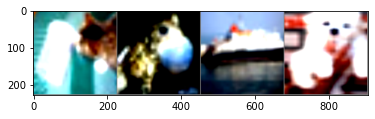

  cat  frog  ship   dog


In [100]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize  还原被归一化的数据
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    #
    plt.show()


# get some random training images
dataiter = iter(trainloader)    #可迭代的对象
images, labels = dataiter.next()  #相当于list里的取第几个，此处每次都会被打乱，所以是随机的四张图。

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## 2. AlexNet

本节主要参考github上Jasonlee1995的资源 https://github.com/Jasonlee1995/AlexNet

In [159]:
import torch.nn as nn

def count(output, target):
    with torch.no_grad():    #with torch.no_grad():，强制之后的内容不进行计算图构建。
        predict = torch.argmax(output, 1)      #返回跨维度张量的最大值的索引。
        correct = (predict == target).sum().item()  #对比后相同的值会为1，不同则会为0，将所有的值相加，得到的仍是tensor类别的int值，item()转成python数字
        return correct

这一步主要是在定义计算预测值和真实值之间有多少不一样的一个函数。

In [160]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), nn.ReLU(inplace=True))  
        #第一层卷积层，定义卷积核为3个batch，96通道，11*11的大小，步长为4，填充为2，用Relu作为激活函数
        #nn.Sequential模块将按照它们在构造函数中被传递的顺序添加
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        #池化层，基本参数，一共六个：

        #kernel_size ：表示做最大池化的窗口大小，可以是单个值，也可以是tuple元组
        #stride ：步长，可以是单个值，也可以是tuple元组
        #padding ：填充，可以是单个值，也可以是tuple元组
        #dilation ：控制窗口中元素步幅
        #return_indices ：布尔类型，返回最大值位置索引
        #ceil_mode ：布尔类型，为True，用向上取整的方法，计算输出形状；默认是向下取整。
        
        self.norm1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        #局部响应归一化层
        
        self.conv2 = nn.Sequential(nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2), nn.ReLU(inplace=True))
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        
        self.conv3 = nn.Sequential(nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        self.conv4 = nn.Sequential(nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2), nn.ReLU(inplace=True))
        
        self.conv5 = nn.Sequential(nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2), nn.ReLU(inplace=True))
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        #一共五层卷积层，三层池化层
        
        self.fc1 = nn.Sequential(nn.Linear(256 * 6 * 6, 4096), nn.ReLU(inplace=True), nn.Dropout())
        self.fc2 = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU(inplace=True), nn.Dropout())
        self.fc3 = nn.Sequential(nn.Linear(4096, num_classes))
        
        # 3个全连接层
        
        self.softmax = nn.Softmax(dim=-1)
        
        #当dim=-1时， 是对某一维度的行进行softmax运算
        
    def forward(self, x):   #前向传播的步骤
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.norm1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.norm2(x)
        
        x = self.conv3(x)
        
        x = self.conv4(x)
        
        x = self.conv5(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

这一步主要是在定义模型，pytorch里的各模型在基类nn.model的基础上进行扩展。

In [161]:
import torch.optim as optim   
import os

class AlexNet2():
    def __init__(self, num_classes=1000, #gpu_id=0,
                 print_freq=10, epoch_print=10):  #原来的代码用gpu，改成了不用gpu
        self.num_classes = num_classes
       #self.gpu = gpu_id
        self.print_freq = print_freq
        self.epoch_print = epoch_print

        #torch.cuda.set_device(self.gpu)

        #self.loss_function = nn.CrossEntropyLoss().cuda(self.gpu)
        
        self.loss_function = nn.CrossEntropyLoss() #计算损失函数
        
        #self.model = model.AlexNet(self.num_classes).cuda() 原来model在另一个.py中，所以这里需要改一下
        
        self.model = AlexNet(self.num_classes)  #这里一直报错，需要调用前面的AlexNet，但是原作者是不同的py文件中调用，所以这里干脆把名字改成AlexNet2

        self.train_losses = []  #损失，成本
        self.train_acc = []   #准确度
        self.test_losses = []  #测试集的损失
        self.test_acc = []  #测试集准确度
        self.best_acc = 0   #记录最好的准确度


    def train(self, train_data, test_data, save, epochs, lr, momentum, weight_decay):
        self.model.train()  #开始训练啦！
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=momentum, weight_decay=weight_decay)
        #SGD随机梯度下降法，
        #params (iterable) – 待优化参数的iterable或者是定义了参数组的dict
        #lr (float) – 学习率
        #momentum (float, 可选) – 动量因子（默认：0）
        #weight_decay (float, 可选) – 权重衰减（L2惩罚）（默认：0）
        #dampening (float, 可选) – 动量的抑制因子（默认：0）
        #nesterov (bool, 可选) – 使用Nesterov动量（默认：False）
        
        for epoch in range(epochs):   #epoch是迭代次数，所以这里开始循环
            if epoch % self.epoch_print == 0: print('Epoch {} Started...'.format(epoch+1))  #隔一段时间print？
            for i, (X, y) in enumerate(train_data): #enumerate就是枚举的意思，把元素一个个列举出来，第一个是什么，第二个是什么，所以返回的是元素以及对应的索引
                #X, y = X.cuda(self.gpu, non_blocking=True), y.cuda(self.gpu, non_blocking=True)
                output = self.model(X)      #将观测代入模型，输出预测值
                loss = self.loss_function(output, y)  #计算成本

                optimizer.zero_grad()   #把梯度置零，也就是把loss关于weight的导数变成0
                loss.backward()      #后向传播啦！
                optimizer.step()   #这个方法会更新所有的参数，就是后向传播之后进行优化了

                if (i+1) % self.print_freq == 0:   #这里应该是在控制每隔几次优化之后，输出当前的Accuracy
                    train_acc = 100 * count(output, y) / y.size(0)  #用到了util，相同的次数/总的次数
                    test_acc, test_loss = self.test(test_data)   #计算测试集的准确的和loss

                    self.train_losses.append(loss.item())
                    #为什么loss要加.item（）
                    #这是因为输出的loss的数据类型是Variable。
                    #而PyTorch的动态图机制就是通过Variable来构建图。
                    #主要是使用Variable计算的时候，会记录下新产生的Variable的运算符号，在反向传播求导的时候进行使用。
                    #如果这里直接将loss加起来，系统会认为这里也是计算图的一部分，也就是说网络会一直延伸变大
                    self.train_acc.append(train_acc)
                    self.test_losses.append(test_loss)
                    self.test_acc.append(test_acc)

                    #以上都在往列表里加每次更新的loss和accu
                    
                    if epoch % self.epoch_print == 0:
                        state = ('Iteration : {} - Train Loss : {:.4f}, Test Loss : {:.4f}, '
                                 'Train Acc : {:.4f}, Test Acc : {:.4f}').format(i+1, loss.item(), test_loss, train_acc, test_acc)
                        if test_acc > self.best_acc:
                            print()
                            print('*' * 35, 'Best Acc Updated', '*' * 35)
                            print(state)
                            self.best_acc = test_acc
                            if save:
                                torch.save(self.model.state_dict(), './best.pt') #更新最好的accu
                                print('Saved Best Model')
                        else: print(state)
   
    def test(self, test_data):   #测试集的函数
        correct, total = 0, 0
        losses = list()

        self.model.eval()
        #model.eval()不启用 BatchNormalization 和 Dropout，将BatchNormalization和Dropout置为False
        with torch.no_grad():
            for i, (X, y) in enumerate(test_data):
                #X, y = X.cuda(self.gpu, non_blocking=True), y.cuda(self.gpu, non_blocking=True)
                X, y = X.cuda(), y.cuda()
                n, crop, _, _, _ = X.shape
                outputs = []
                for j in range(crop):
                    outputs.append(self.model(X[:,j,:,:,:]))
                outputs = torch.stack(outputs)
                output = torch.mean(outputs, dim=0)

                loss = self.loss_function(output, y)
                losses.append(loss.item())

                correct += count(output, y)
                total += y.size(0)
                
        self.model.train()
        return (100*correct/total, sum(losses)/len(losses))

In [162]:
batch_size=128
num_classes = 10

#gpu_id = 4
print_freq = 130
epoch_print = 20

save = True
epochs = 401

lr = 0.01
momentum = 0.9
weight_decay = 0.0005

In [163]:
AlexNet = AlexNet2(num_classes=num_classes, print_freq=print_freq, epoch_print=epoch_print)

AttributeError: 'AlexNet2' object has no attribute 'to'

In [164]:
AlexNet.train(trainloader, testloader, save, epochs, lr, momentum, weight_decay)

Epoch 1 Started...


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

 报错Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
 这个问题解决不了。

## 3. 官方教程：卷积神经网络

参考：https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [182]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [183]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)             #定义卷积层和池化层
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)       #定义全连接层
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [184]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()         #用交叉熵作loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  #随机梯度下降法

In [185]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data          

        # zero the parameter gradients
        optimizer.zero_grad()       #梯度从零开始

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.173
[1,  4000] loss: 1.846
[1,  6000] loss: 1.648
[1,  8000] loss: 1.558
[1, 10000] loss: 1.503
[1, 12000] loss: 1.433
[2,  2000] loss: 1.373
[2,  4000] loss: 1.378
[2,  6000] loss: 1.335
[2,  8000] loss: 1.309
[2, 10000] loss: 1.301
[2, 12000] loss: 1.265
Finished Training


在测试集上进行测试

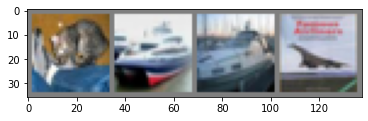

GroundTruth:    cat  ship  ship plane


In [186]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [187]:
outputs = net(images)

In [188]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


In [189]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)        #放进模型里
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  #相同的累加

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [190]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}  #定义列表
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 65.3 %
Accuracy for class car   is: 66.1 %
Accuracy for class bird  is: 34.9 %
Accuracy for class cat   is: 27.6 %
Accuracy for class deer  is: 36.9 %
Accuracy for class dog   is: 37.9 %
Accuracy for class frog  is: 78.5 %
Accuracy for class horse is: 66.6 %
Accuracy for class ship  is: 57.0 %
Accuracy for class truck is: 72.7 %


显示每个种类的准确度。

## 4. 自定义卷积神经网络

In [197]:
train_transform = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(256), transforms.RandomCrop(224), transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), transforms.Normalize(mean=[0.4921, 0.4828, 0.4474], std=[0.1950, 0.1922, 0.1940])])

test_transform = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(256), transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    transforms.Lambda(lambda crops: torch.stack([transforms.Normalize(mean=[0.4921, 0.4828, 0.4474], 
                                                                       std=[0.1950, 0.1922, 0.1940])(crop) for crop in crops]))
    ])  #resize 图像的大小，不然后面会报错


In [198]:

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True,  num_workers=0, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [202]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()              #使用AlexNet的定义
        self.conv1 = nn.Sequential(nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), nn.ReLU(inplace=True))  
        #第一层卷积层，定义卷积核为3个batch，96通道，11*11的大小，步长为4，填充为2，用Relu作为激活函数
        #nn.Sequential模块将按照它们在构造函数中被传递的顺序添加
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        #池化层，基本参数，一共六个：

        #kernel_size ：表示做最大池化的窗口大小，可以是单个值，也可以是tuple元组
        #stride ：步长，可以是单个值，也可以是tuple元组
        #padding ：填充，可以是单个值，也可以是tuple元组
        #dilation ：控制窗口中元素步幅
        #return_indices ：布尔类型，返回最大值位置索引
        #ceil_mode ：布尔类型，为True，用向上取整的方法，计算输出形状；默认是向下取整。
        
        self.norm1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        #局部响应归一化层
        
        self.conv2 = nn.Sequential(nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2), nn.ReLU(inplace=True))
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        
        self.conv3 = nn.Sequential(nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True))
        
        self.conv4 = nn.Sequential(nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2), nn.ReLU(inplace=True))
        
        self.conv5 = nn.Sequential(nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2), nn.ReLU(inplace=True))
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        #一共五层卷积层，三层池化层
        
        self.fc1 = nn.Sequential(nn.Linear(256 * 6 * 6, 4096), nn.ReLU(inplace=True), nn.Dropout())
        self.fc2 = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU(inplace=True), nn.Dropout())
        self.fc3 = nn.Sequential(nn.Linear(4096, num_classes))

    def forward(self, x):   #前向传播的步骤
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.norm1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.norm2(x)
        
        x = self.conv3(x)
        
        x = self.conv4(x)
        
        x = self.conv5(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


net = Net()

In [203]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()         #用交叉熵作loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  #随机梯度下降法

In [204]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data          

        # zero the parameter gradients
        optimizer.zero_grad()       #梯度从零开始

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.299
[1,  4000] loss: 2.057
[1,  6000] loss: 1.792
[1,  8000] loss: 1.653
[1, 10000] loss: 1.562
[1, 12000] loss: 1.454
[2,  2000] loss: 1.344
[2,  4000] loss: 1.295
[2,  6000] loss: 1.251
[2,  8000] loss: 1.167
[2, 10000] loss: 1.129
[2, 12000] loss: 1.077
Finished Training


loss变小了。